In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [35]:

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width',500)

In [36]:
df=pd.read_csv('/content/train_odev.csv')

print(df.head())
print(df.shape) #kayıt sayısı,nitelik sayısı
print(df.info()) #nitelik tip bilgisi


   battery  blue  speed  dual_sim  fcamera  g4  memory  pdepth  pweight  cores  pcamera  px_height  px_width  sheight  swidth  talk_time  g3  touch_screen  wifi  price_range
0      842     0    2.2         0        1   0       7     0.6      188      2        2         20       756        9       7         19   0             0     1            1
1     1021     1    0.5         1        0   1      53     0.7      136      3        6        905      1988       17       3          7   1             1     0            2
2      563     1    0.5         1        2   1      41     0.9      145      5        6       1263      1716       11       2          9   1             1     0            2
3      615     1    2.5         0        0   0      10     0.8      131      6        9       1216      1786       16       8         11   1             0     0            2
4     1821     1    1.2         0       13   1      44     0.6      141      2       14       1208      1212        8       2     

In [37]:
#niteliklerin hepsi sayısal lakin kategorik olanlar olabilir.
def grab_col_names(df,cat_th=10,car_th=20):
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ['category', 'object', 'bool']]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes in ['int', 'float']]
    cat_cols=cat_cols+num_but_cat
    num_cols=[col for col in df.columns if col not in cat_cols]
    print(f'Observation:{df.shape[0]}')
    print(f'Variables:{df.shape[1]}')
    print(f'cat_cols:{len(cat_cols)}')
    print(f'num_cols:{len(num_cols)}')
    return cat_cols,num_cols,num_but_cat

cat_cols,num_cols,num_but_cat=grab_col_names(df,cat_th=10,car_th=20)
print(df[num_cols].describe().T) #5 sayı özeti

Observation:1200
Variables:20
cat_cols:8
num_cols:12
            count         mean         std    min    25%     50%      75%     max
battery    1200.0  1239.906667  442.722035  501.0  845.5  1231.5  1619.25  1998.0
speed      1200.0     1.492500    0.821212    0.5    0.6     1.4     2.20     3.0
fcamera    1200.0     4.365833    4.355204    0.0    1.0     3.0     7.00    19.0
memory     1200.0    31.765000   17.920307    2.0   16.0    31.0    47.00    64.0
pdepth     1200.0     0.501167    0.285861    0.1    0.2     0.5     0.80     1.0
pweight    1200.0   140.223333   35.596878   80.0  109.0   141.0   170.00   200.0
pcamera    1200.0    10.031667    6.010194    0.0    5.0    10.0    15.00    20.0
px_height  1200.0   666.865000  451.662648    0.0  295.0   594.0   977.25  1949.0
px_width   1200.0  1265.271667  425.400393  500.0  896.0  1260.0  1632.25  1997.0
sheight    1200.0    12.380000    4.223798    5.0    9.0    13.0    16.00    19.0
swidth     1200.0     5.790000    4.409320   

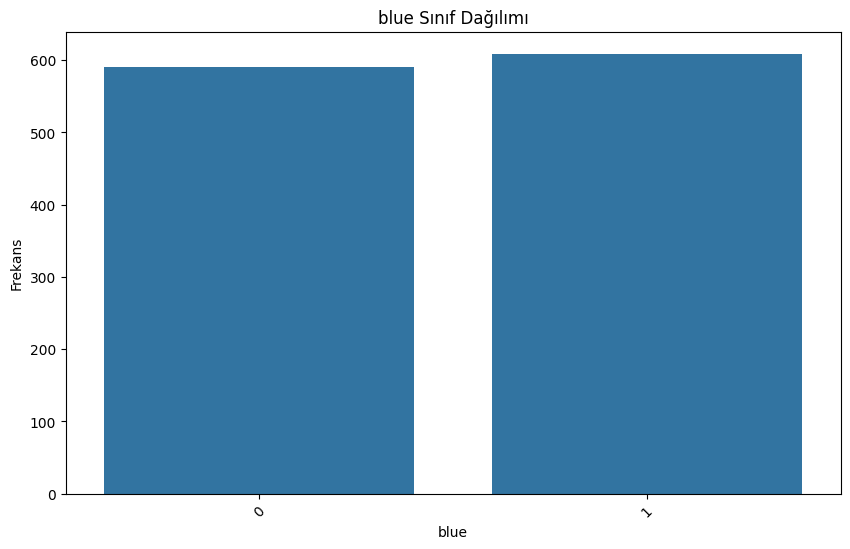

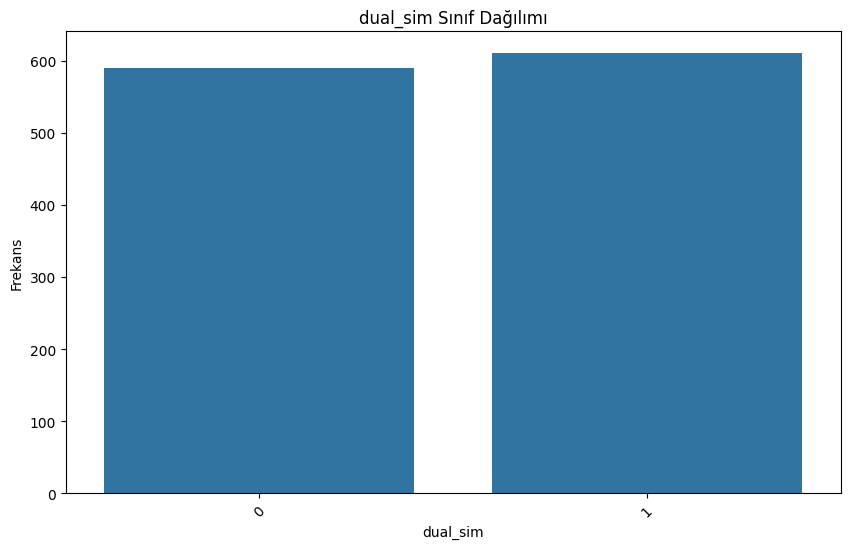

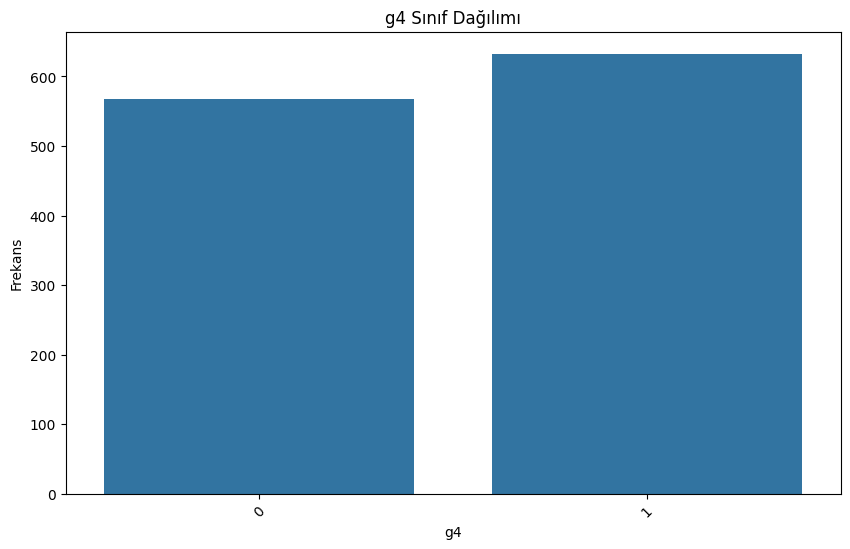

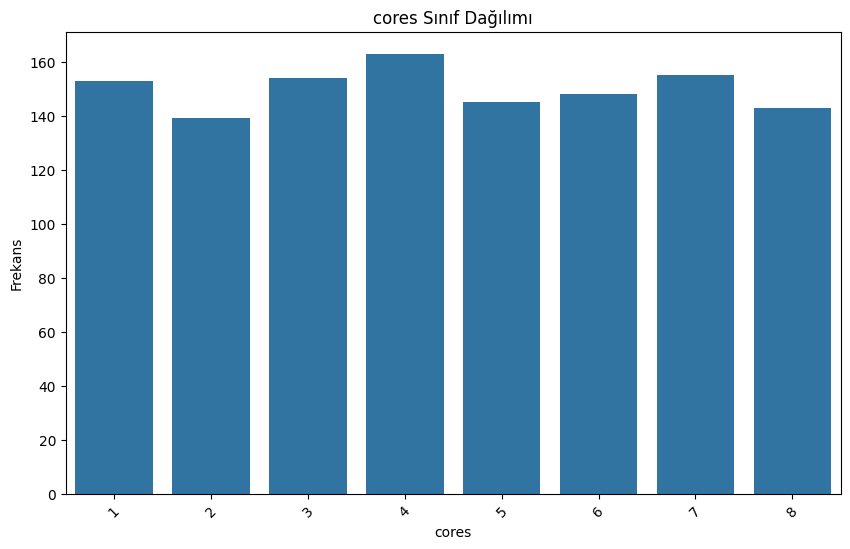

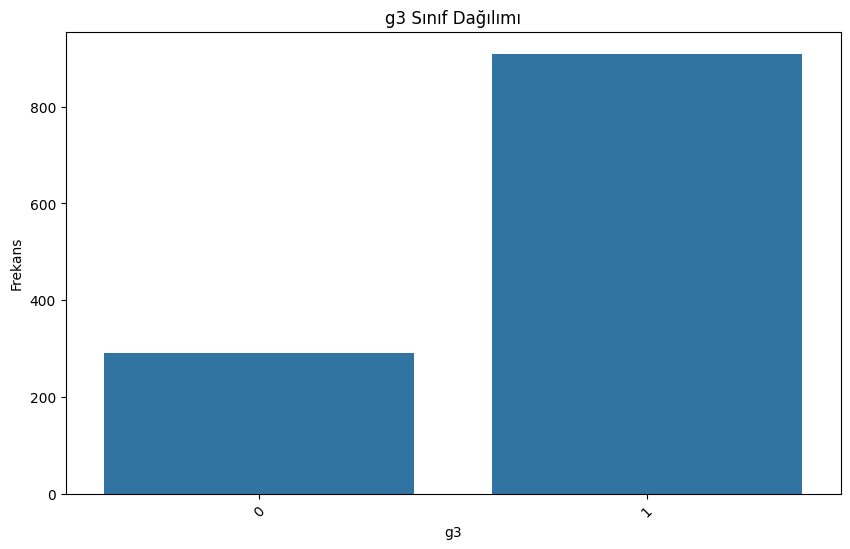

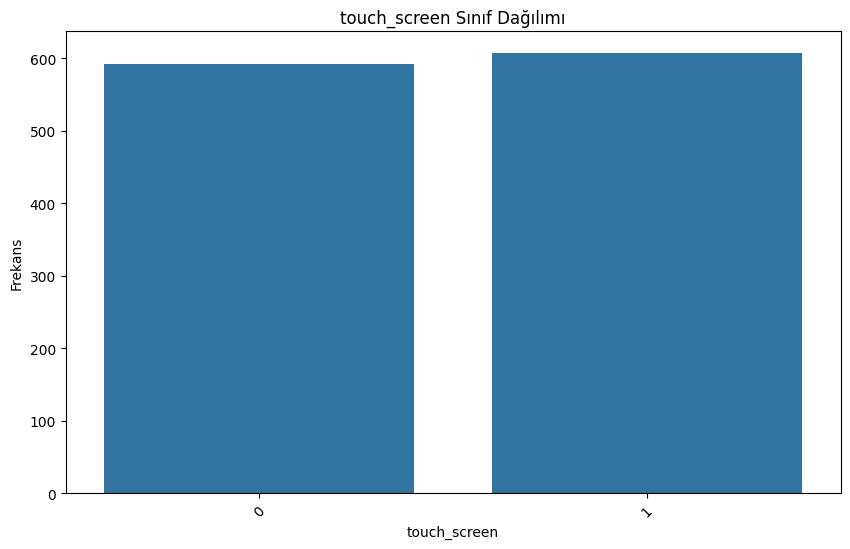

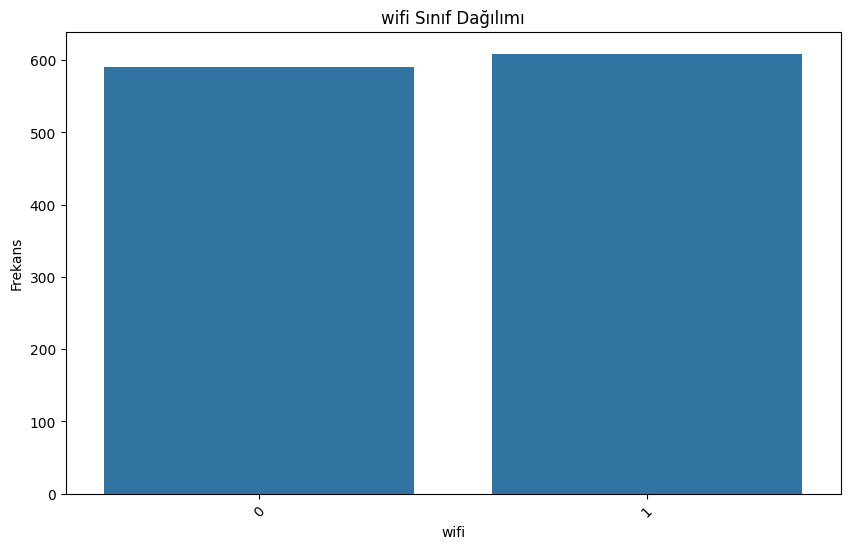

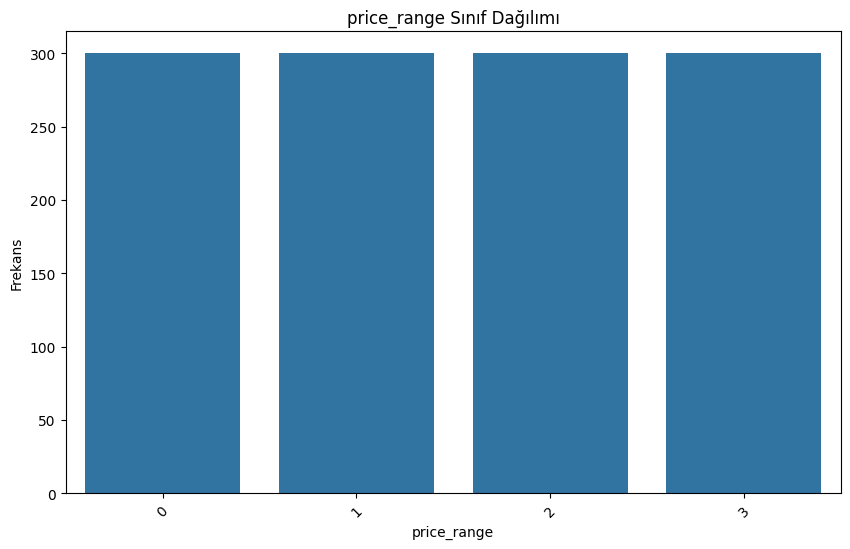

In [38]:
df['price_range'].value_counts()

#kategorik olanlar için
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Sınıf Dağılımı')
    plt.xlabel(col)
    plt.ylabel('Frekans')
    plt.xticks(rotation=45)  # Etiketleri döndürmek, eğer isimler uzun ise
    plt.show()


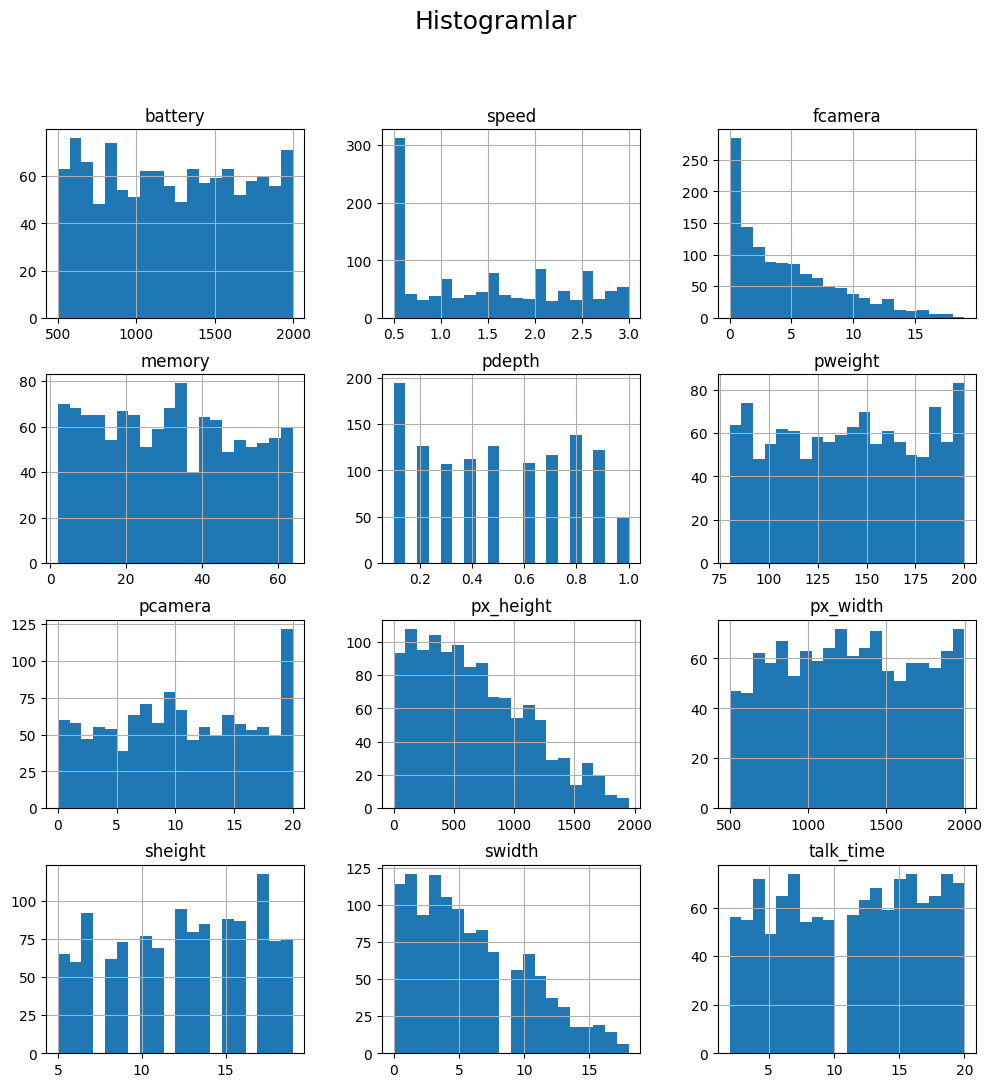

In [39]:
#histogram ile özellik dağılımını inceleme(sayısal değişkenlerin)

df[num_cols].hist(bins=20,figsize=(12,12))
plt.suptitle("Histogramlar",size=18)
plt.show()

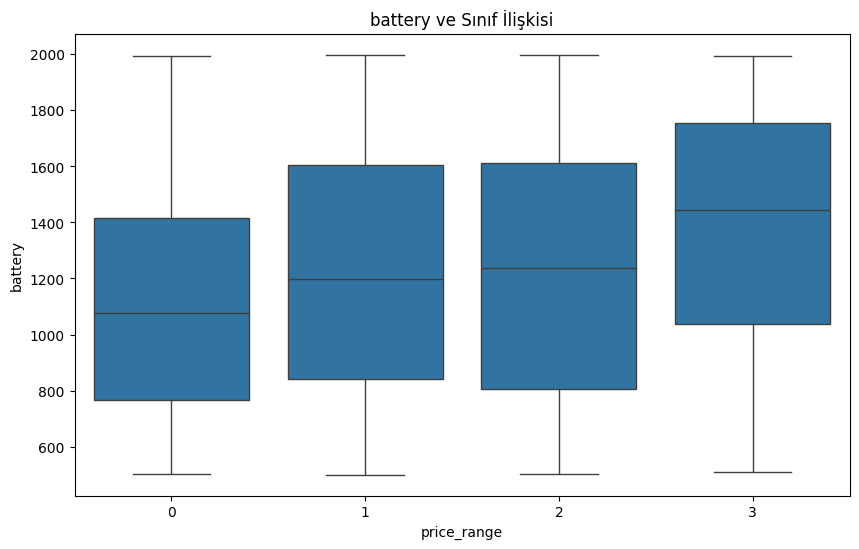

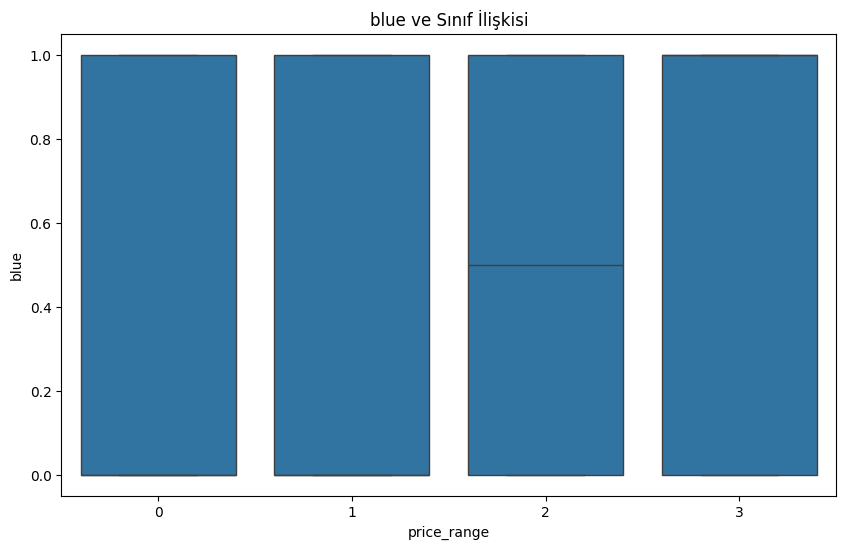

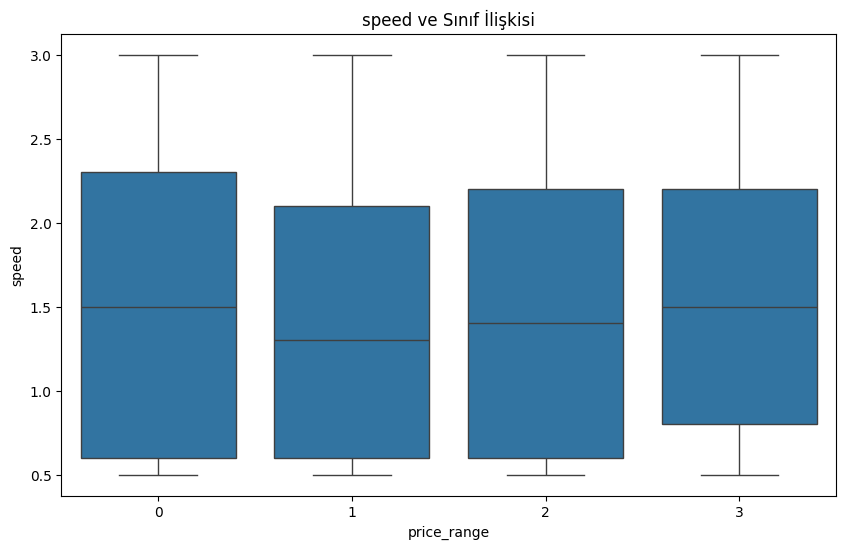

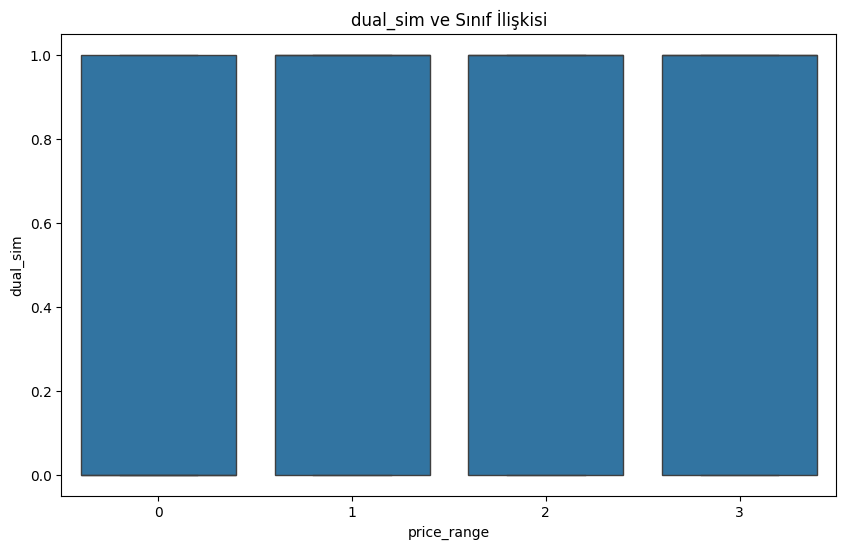

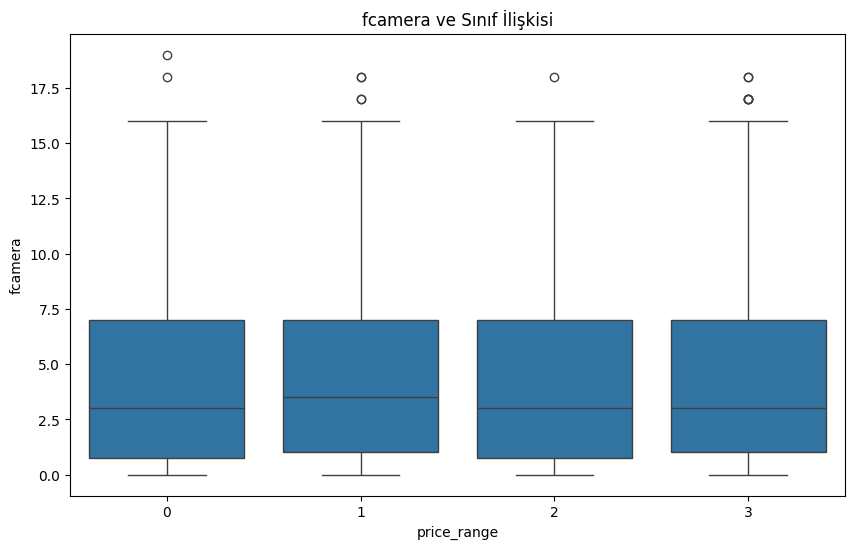

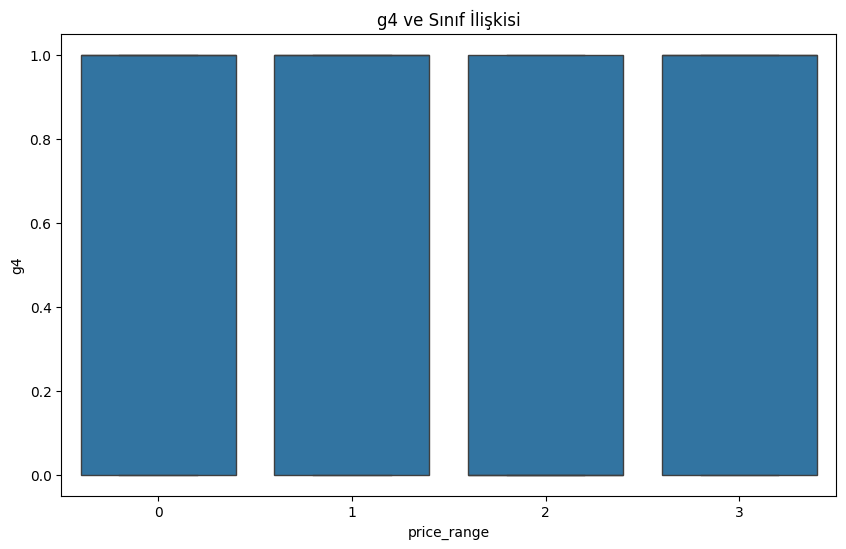

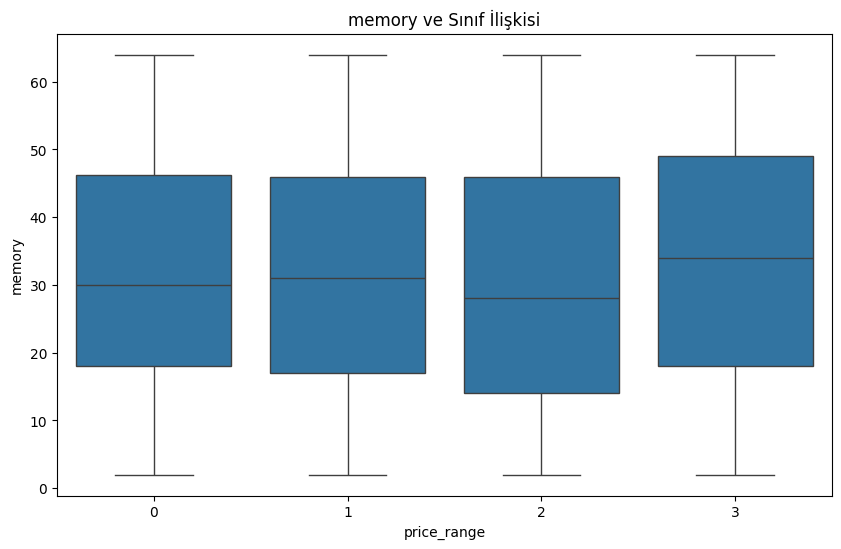

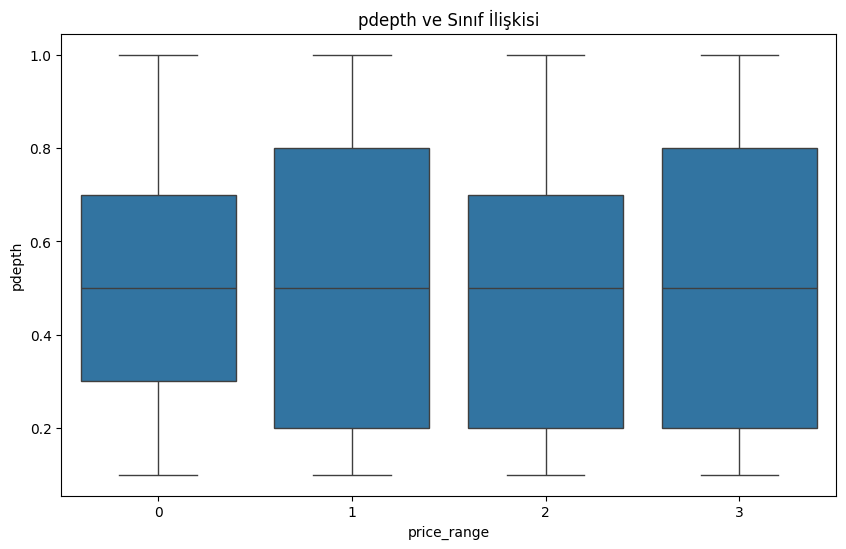

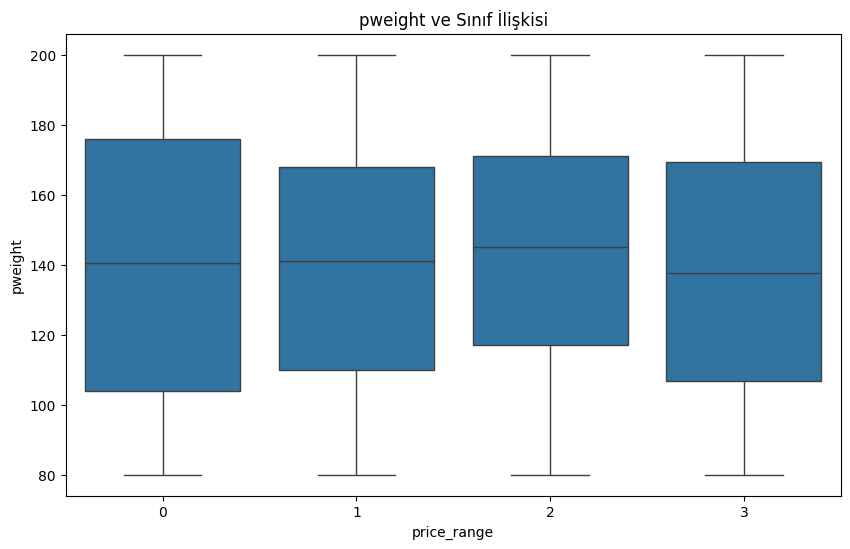

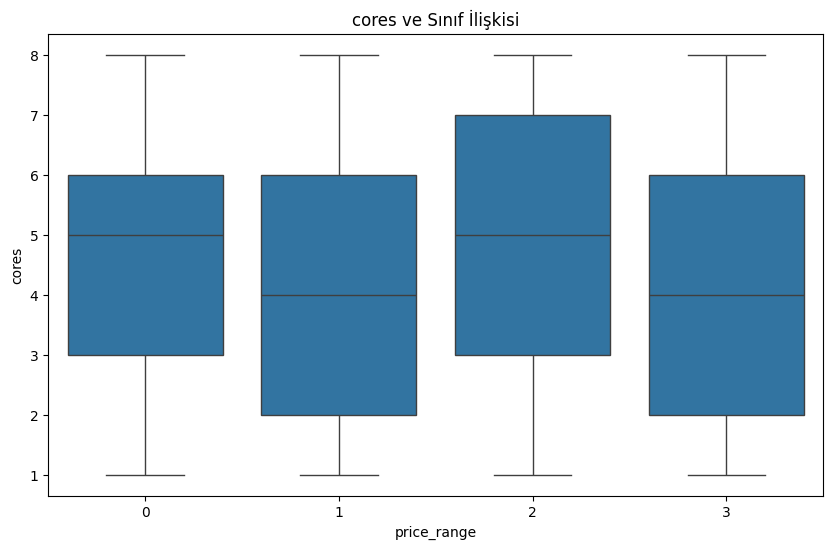

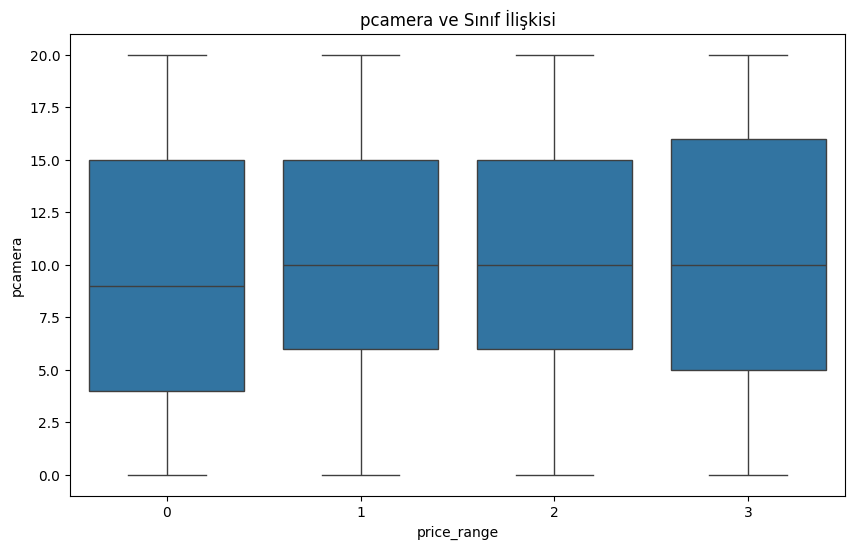

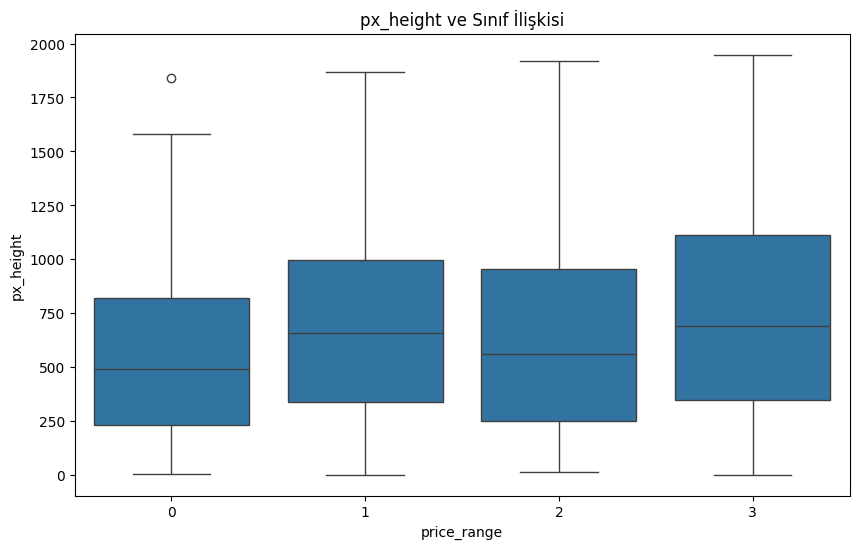

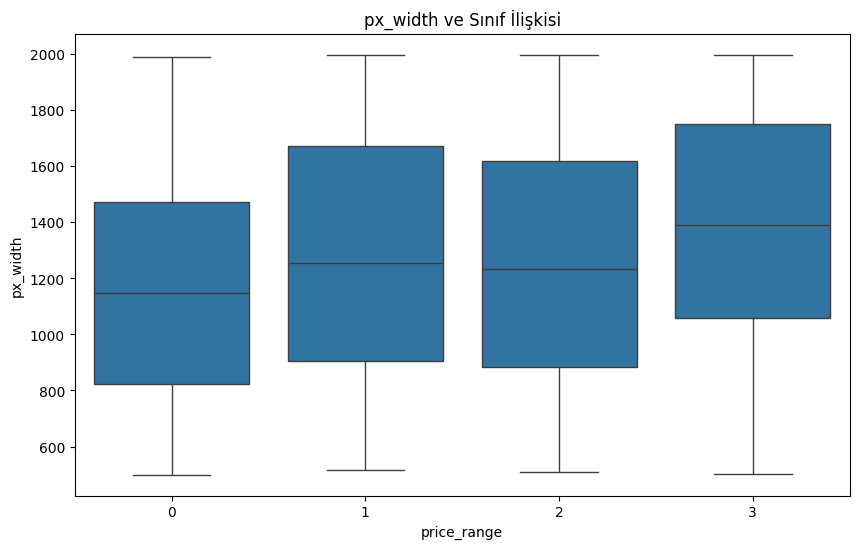

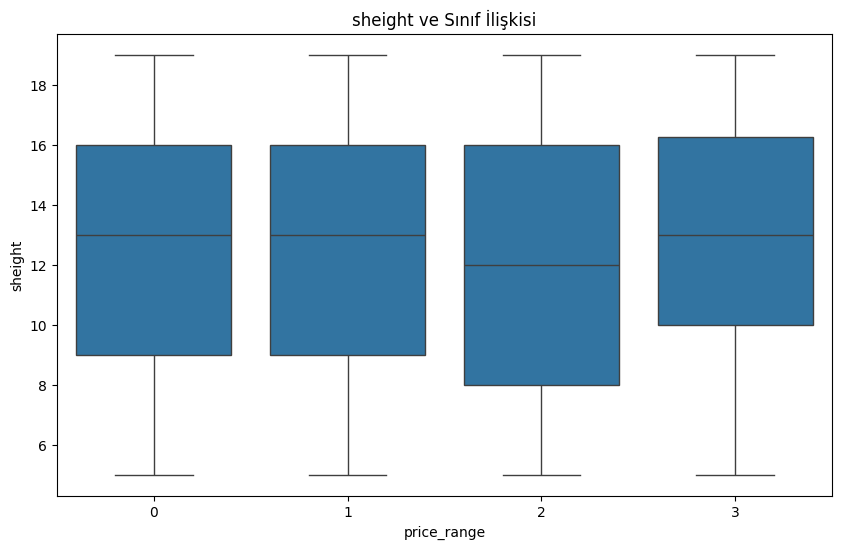

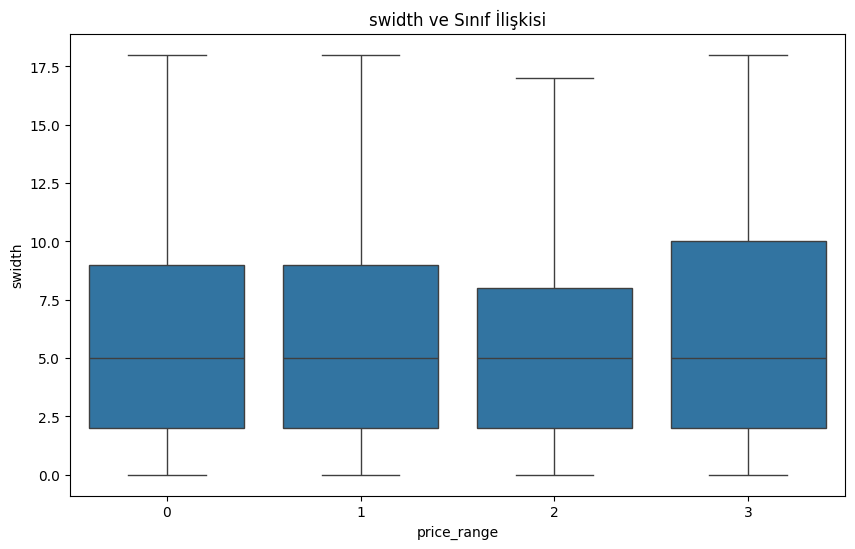

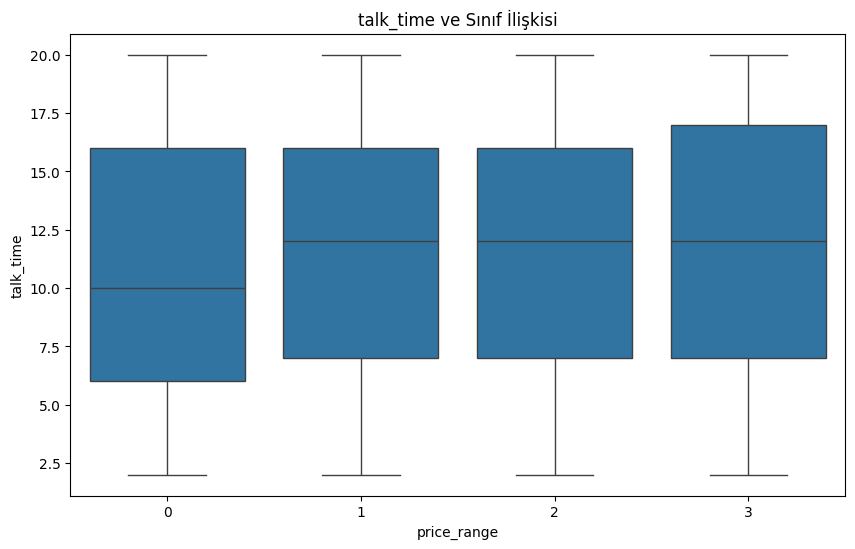

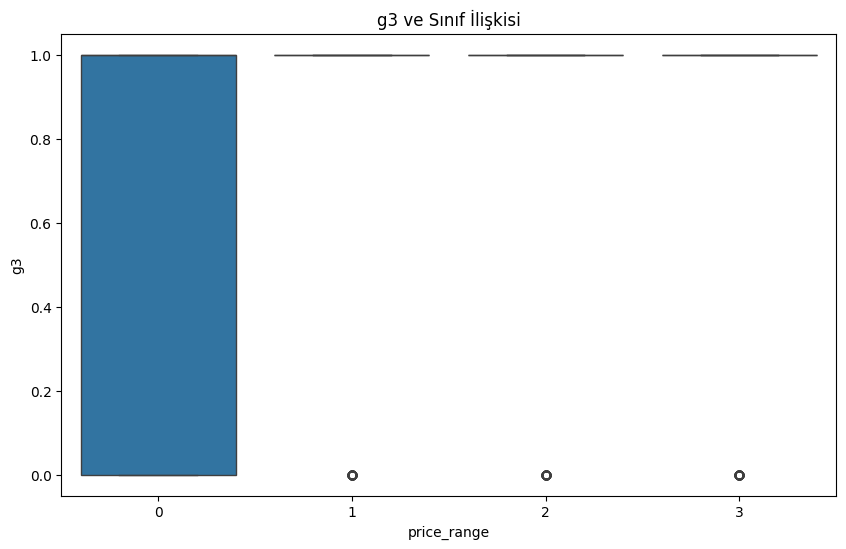

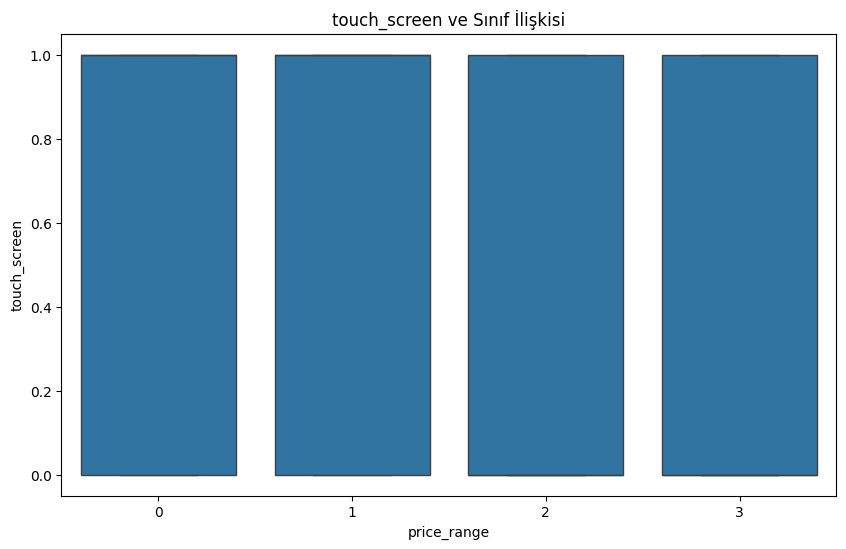

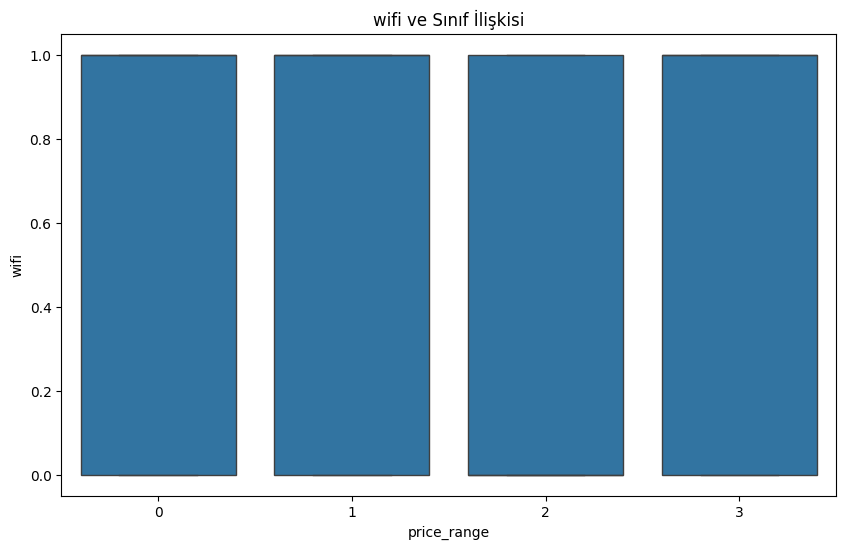

In [40]:
#özelliklerin sınıf etiketiyle ilişkisi
ozellikler = [col for col in df.columns if col != 'price_range']
# Her bir özellik için boxplot çizimi
for ozellik in ozellikler:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price_range', y=ozellik, data=df)
    plt.title(f'{ozellik} ve Sınıf İlişkisi')
    plt.show()

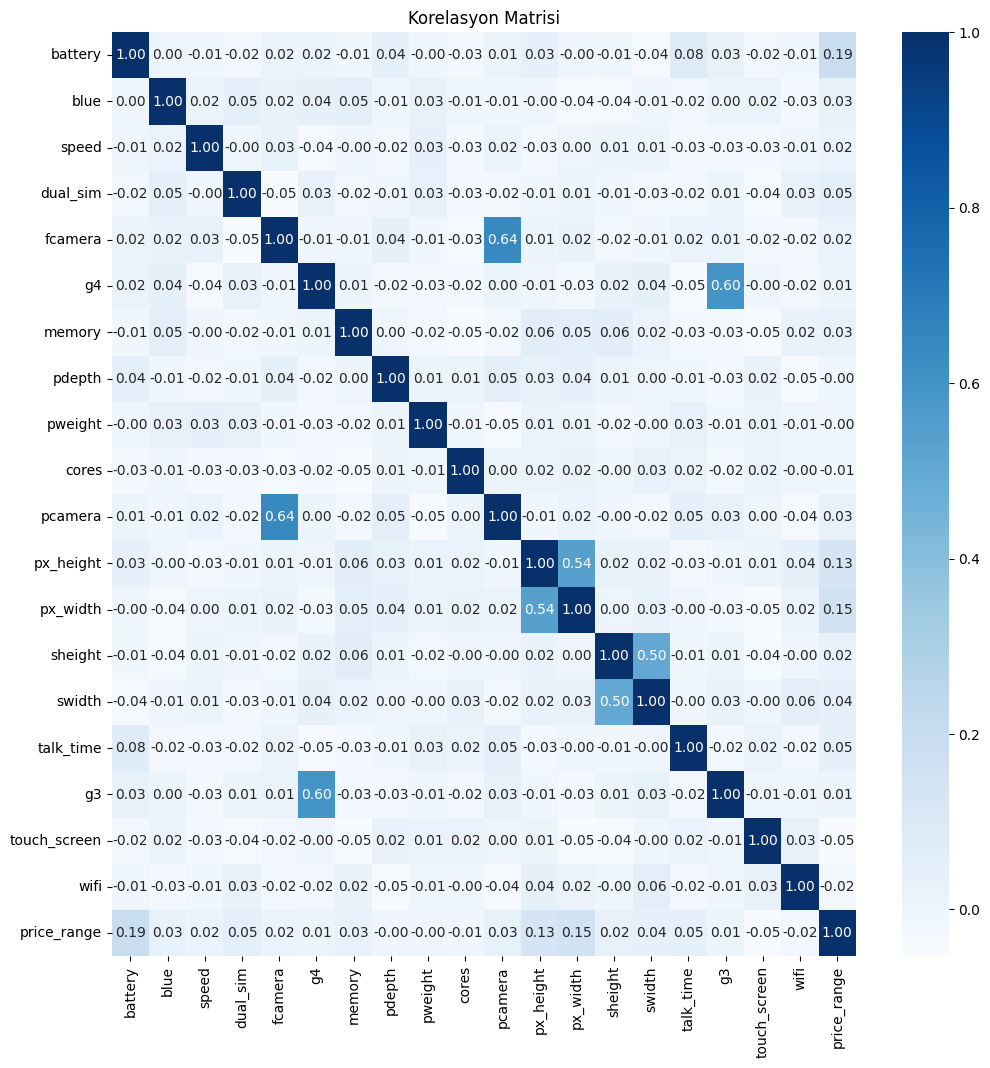

In [41]:
plt.figure(figsize=(12, 12))
correlation_matrix = df.select_dtypes(include=["number"]).corr()

sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

In [42]:
df['px_height'] = df['px_height'].replace(0, df['px_height'].mean())
df['swidth'] = df['swidth'].replace(0, df['swidth'].mean())

In [8]:
df.duplicated().sum()

0

In [43]:
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quantile1=dataframe[col_name].quantile(q1)
    quantile3=dataframe[col_name].quantile(q3)

    iqr=quantile3-quantile1

    up_limit=quantile3+1.5*iqr
    low_limit=quantile1-1.5*iqr
    return low_limit, up_limit

#aykırı değer var mı yokmu hesaplama:
def check_outliers(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name]<low_limit)|(dataframe[col_name]>up_limit)].any(axis=None):
        print(col_name)
        return True
    else:
        return False
for col in num_cols:
    print(check_outliers(df,col))
def replace_with_thresholds(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    # Veri tipine uygun dönüşüm
    if dataframe[col_name].dtype in ['int64', 'int32']:
        low_limit = int(low_limit)
        up_limit = int(up_limit)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

for col in num_cols:
    replace_with_thresholds(df,col)

for col in num_cols:
    print(check_outliers(df,col))

False
False
fcamera
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [44]:
print(df.isnull().sum()) #eksik değer yok

battery         0
blue            0
speed           0
dual_sim        0
fcamera         0
g4              0
memory          0
pdepth          0
pweight         0
cores           0
pcamera         0
px_height       0
px_width        0
sheight         0
swidth          0
talk_time       0
g3              0
touch_screen    0
wifi            0
price_range     0
dtype: int64


<ipython-input-45-a93c64dcb385>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1099.3428306   972.34713977 1129.53770762 1304.60597128  953.16932506
  953.17260861 1315.8425631  1153.48694583  906.10512281 1108.51200872
  907.31646144  906.85404929 1048.39245431  617.34395107  655.0164335
  887.54249415  797.43377593 1062.84946652  818.3951849   717.53925973
 1293.12975378  954.8447399  1013.50564094  715.05036276  891.12345509
 1022.18451794  769.80128452 1075.13960367  879.87226202  941.66125004
  879.65867755 1370.4556369   997.30055505  788.45781421 1164.50898242
  755.83127001 1041.772719    608.06597522  734.36279022 1039.37224717
 1147.693316   1034.27365624  976.87034352  939.77926088  704.29560193
  856.03115832  907.87224581 1211.42444524 1068.72365791  647.39196893
 1064.81679388  922.98354392  864.61559994 1122.33525777 1206.1999045
 1186.25602382  832.15649536  938.15752483 1066.25268628

Korelasyon: 0.9028266731778808
   price_range          ram
0            1  1099.342831
1            2  1251.301497
2            2  1331.945688
3            2  1724.188082
4            1   972.347140


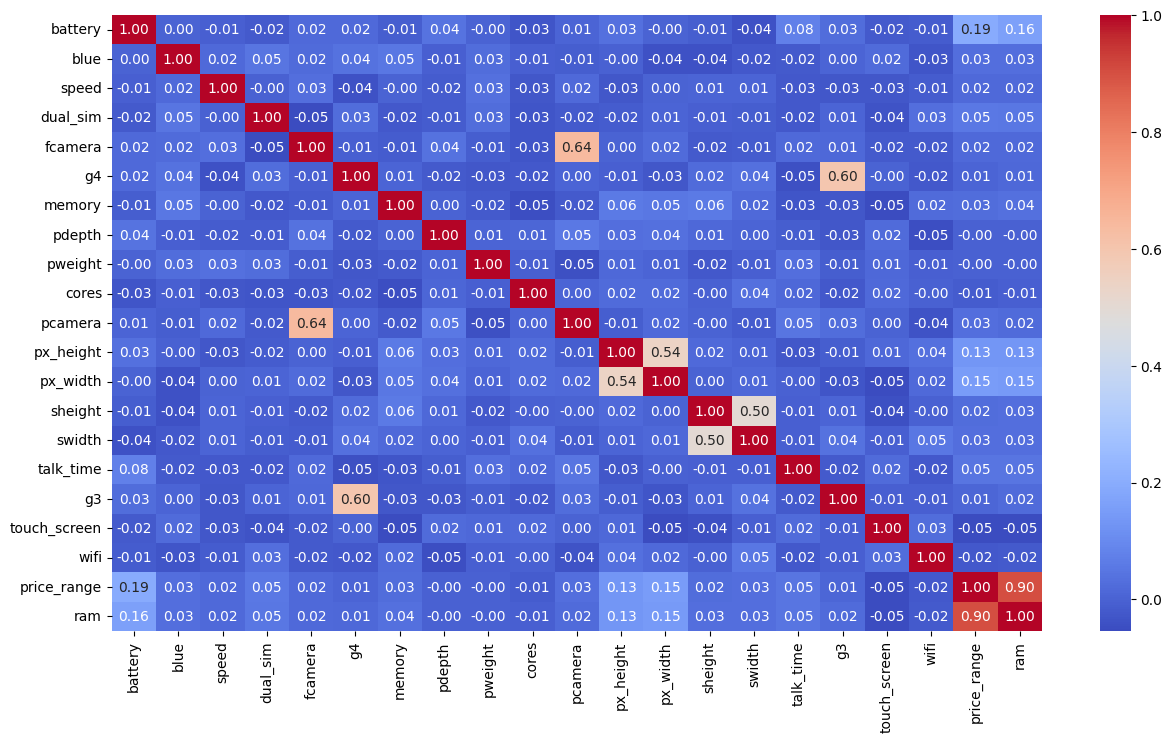

In [45]:



df['ram'] = 0  # Yeni bir sütun eklendi

# Price Range'e göre RAM değerleri
np.random.seed(42)  # Rastgeleliği kontrol et
for price in df['price_range'].unique():
    base_ram = (price + 1) * 500  # Her price_range için base RAM değeri
    #noise = np.random.normal(0, 150, len(df[df['price_range'] == price]))  # Gürültü
    noise = np.random.normal(0, (price + 1) * 100, len(df[df['price_range'] == price]))

    df.loc[df['price_range'] == price, 'ram'] = base_ram + noise

# Korelasyonu kontrol edelim
correlation = df['price_range'].corr(df['ram'])
print("Korelasyon:", correlation)

# Sonuçları inceleyin
print(df[['price_range', 'ram']].head())
plt.figure(figsize=(15, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()







Doğruluk: 0.8208333333333333
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        57
           1       0.77      0.85      0.81        55
           2       0.69      0.68      0.68        59
           3       0.91      0.77      0.83        69

    accuracy                           0.82       240
   macro avg       0.82      0.83      0.82       240
weighted avg       0.82      0.82      0.82       240



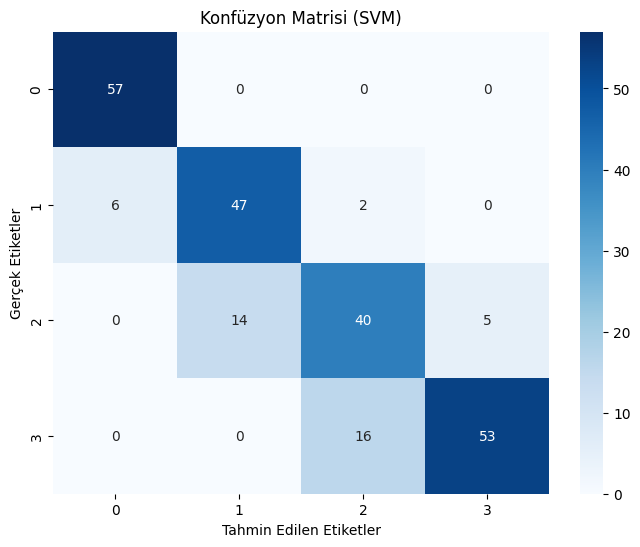

In [48]:



# 1. Hedef ve özellikler
X = df.drop(columns=["price_range"])  # Bağımsız değişkenler
y = df["price_range"]  # Hedef değişken

# 2. Veri setini eğitim ve test setlerine ayırma (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# 3. Model: Support Vector Machine (SVM)
model2 = SVC(random_state=42)  # SVM modelini başlatıyoruz
model2.fit(X_train, y_train)  # Modeli eğitme

# 4. Tahmin yapma ve doğruluk değerlendirme
y_pred = model2.predict(X_test)

# Doğruluk
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk:", accuracy)

# Sınıflandırma raporu
report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", report)

# Konfüzyon matrisi
conf_matrix = confusion_matrix(y_test, y_pred)

# Konfüzyon matrisinin görselleştirilmesi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model2.classes_, yticklabels=model2.classes_)
plt.title("Konfüzyon Matrisi (SVM)")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

In [50]:
import pickle

# Modeli .pkl dosyasına kaydet
with open('model.pkl', 'wb') as file:
    pickle.dump(model2, file)

print("Model başarıyla 'model.pkl' olarak kaydedildi!")


Model başarıyla 'model.pkl' olarak kaydedildi!


In [51]:
from google.colab import files

# Dosyayı indir
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>